### Here, I will train an Isolation Forest model on the million transaction dataset

In [47]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import sys
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# SCRIPT
sys.path.append(os.path.abspath(".."))
from scripts import conversions

### Preprocess (sanity check)

In [10]:
df = pd.read_csv('../data/full_transactions.csv')
df

,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,223837,180.411926,2025-02-14 10:16:10,-0.011788
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.000000,153985,81.237520,2025-02-14 10:16:10,-0.011788
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.000000,223550,65.091946,2025-02-14 10:16:11,-0.011788
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.000000,500002,63.063619,2025-02-14 10:16:11,-0.011788
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,252997,47.995919,2025-02-14 10:16:11,-0.011788
...,...,...,...,...,...,...,...,...
1000460,0x8cbf01dc0bbebe854a64ccd7e9ccee8876c95ee30cfb...,0x5698D4ec03802438Bce268b02eb3817B8C3C2b3f,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0.000000,45758,1.919426,2025-02-17 06:06:35,-0.011788
1000461,0xb0fac9da7e21836663a05e8bcfd429a64e66160f10d7...,0x5baBE600b9fCD5fB7b66c0611bF4896D967b23A1,0xf45AFF520a8Ebe59f513719fc78b164e375Dd1f4,0.007562,21000,1.917395,2025-02-17 06:06:35,-0.011718
1000462,0x488d4e454120b061f3a0c41008b90d1156737845d91a...,0x99719eacc100BD48D4dbEb96E990333a7601e5B8,0x65c55F33F9493E8702FEea89B4fA357283eD3841,0.000000,302687,1.917395,2025-02-17 06:06:35,-0.011788
1000463,0xcdda18972b9baf4310ce4be72d1ec91dc32bb2f02c6b...,0x6a0913BA185848c09250D3F40DFf29dC45530978,0xb965602E41Af7A92B3F4b48729736Aded9C94E47,0.000000,500000,1.913384,2025-02-17 06:06:35,-0.011788


In [50]:
def create_additional_features(df):
    df['gas_fee_ratio'] = df['gas_price'] / df['gas_used']
    df['txn_speed'] = df['gas_price'] * df['gas_used']

def train_isolation_forest(df, n_estimators, contamination, random_state=42):

    # Drop dupes/na (sanity check)
    print(f'Data count before cleaning: {len(df)}')
    df.dropna(inplace=True)
    df.drop_duplicates(subset=['hash'], inplace=True)
    print(f'Data count after cleaning: {len(df)}')

    create_additional_features(df)

    features = ['value', 'gas_price', 'gas_used', 'gas_fee_ratio', 'txn_speed']
    df_features = df[features].copy()

    pipe = Pipeline([('scaler', StandardScaler()),
                     ('isolation_forest', IsolationForest(n_estimators=n_estimators,
                                                         contamination=contamination,
                                                         random_state=random_state))])
    
    df['anomaly_score'] = pipe.fit_predict(df_features)

    num_anomalies = len(df[df['anomaly_score'] == -1])
    num_normal = len(df[df['anomaly_score'] != -1])
    print(f'Number of anomalies flagged: {num_anomalies}')
    print(f'Number of unflagged points: {num_normal}')

    scores = pipe.named_steps['isolation_forest'].decision_function(df_features)

    plt.figure(figsize=(10, 5))
    sns.histplot(scores, bins=50, kde=True, color='blue')
    plt.xlabel("Anomaly Score", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title("Distribution of Anomaly Scores", fontsize=16, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


    scores = pipe.named_steps['isolation_forest'].decision_function(df[['value', 'gas_price', 'gas_used', 'gas_fee_ratio', 'txn_speed']])
    print(f"Min: {np.min(scores)}\nMax: {np.max(scores)}\nMean: {np.mean(scores)}\nStd Dev: {np.std(scores)}")



One in a hundred transactions will be marked as sus, to be on the safe side

Data count before cleaning: 1000465
Data count after cleaning: 1000465
Number of anomalies flagged: 10000
Number of unflagged points: 990465


c:\Users\seely\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


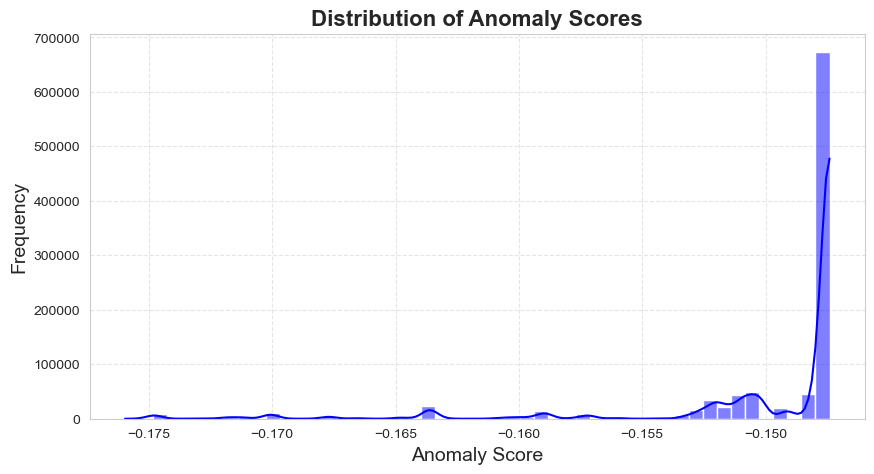

c:\Users\seely\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


Min: -0.17596596802875297
Max: -0.14740664132681958
Mean: -0.1496623928817102
Std Dev: 0.005161935410018025


In [58]:
train_isolation_forest(df, 100, .01)

In [59]:
conversions.convert_eth_usd(df)

,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore,gas_fee_ratio,txn_speed,anomaly_score,gas_cost_eth,total_cost_usd
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,223837,180.411926,2025-02-14 10:16:10,-0.011788,0.000806,4.038286e+07,-1,0.040383,99.459764
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.000000,153985,81.237520,2025-02-14 10:16:10,-0.011788,0.000528,1.250936e+07,-1,0.012509,30.809552
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.000000,223550,65.091946,2025-02-14 10:16:11,-0.011788,0.000291,1.455130e+07,-1,0.014551,35.838699
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.000000,500002,63.063619,2025-02-14 10:16:11,-0.011788,0.000126,3.153194e+07,-1,0.031532,77.660635
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,252997,47.995919,2025-02-14 10:16:11,-0.011788,0.000190,1.214282e+07,-1,0.012143,29.906803
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000460,0x8cbf01dc0bbebe854a64ccd7e9ccee8876c95ee30cfb...,0x5698D4ec03802438Bce268b02eb3817B8C3C2b3f,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0.000000,45758,1.919426,2025-02-17 06:06:35,-0.011788,0.000042,8.782907e+04,1,0.000088,0.216316
1000461,0xb0fac9da7e21836663a05e8bcfd429a64e66160f10d7...,0x5baBE600b9fCD5fB7b66c0611bF4896D967b23A1,0xf45AFF520a8Ebe59f513719fc78b164e375Dd1f4,0.007562,21000,1.917395,2025-02-17 06:06:35,-0.011718,0.000091,4.026529e+04,1,0.000040,18.722909
1000462,0x488d4e454120b061f3a0c41008b90d1156737845d91a...,0x99719eacc100BD48D4dbEb96E990333a7601e5B8,0x65c55F33F9493E8702FEea89B4fA357283eD3841,0.000000,302687,1.917395,2025-02-17 06:06:35,-0.011788,0.000006,5.803704e+05,1,0.000580,1.429406
1000463,0xcdda18972b9baf4310ce4be72d1ec91dc32bb2f02c6b...,0x6a0913BA185848c09250D3F40DFf29dC45530978,0xb965602E41Af7A92B3F4b48729736Aded9C94E47,0.000000,500000,1.913384,2025-02-17 06:06:35,-0.011788,0.000004,9.566922e+05,1,0.000957,2.356256


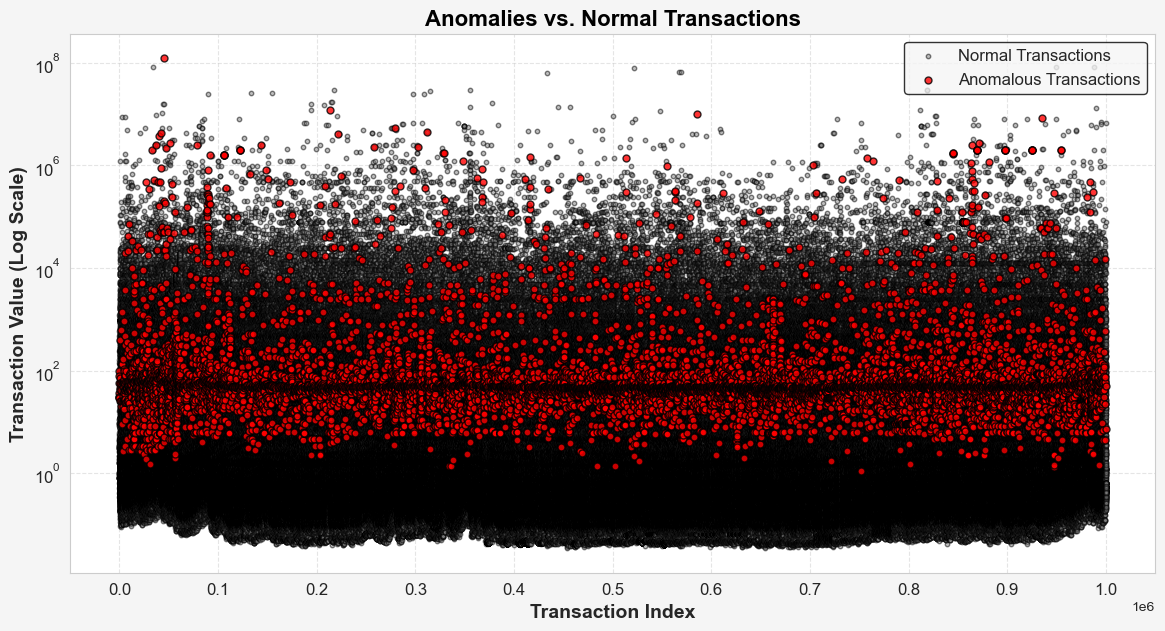

In [60]:
anomaly_values = df[df['anomaly_score'] == -1]['total_cost_usd']
normal_values = df[df['anomaly_score'] != -1]['total_cost_usd']

index_anomaly = anomaly_values.index
index_normal = normal_values.index

sns.set_style("whitegrid")

plt.figure(figsize=(14, 7), facecolor="whitesmoke")

plt.scatter(index_normal, normal_values, 
            linestyle='-', marker='o', 
            s=10, alpha=0.5, 
            color='gray', edgecolor="black", 
            label="Normal Transactions")

plt.scatter(index_anomaly, anomaly_values, 
            linestyle='-', marker='o', 
            s=25, alpha=0.8, 
            color='red', edgecolor="black", 
            label="Anomalous Transactions")

plt.yscale("log")

plt.xticks(np.linspace(0, len(df), num=11, dtype=int), fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Transaction Index', fontsize=14, fontweight='bold')
plt.ylabel('Transaction Value (Log Scale)', fontsize=14, fontweight='bold')
plt.title('Anomalies vs. Normal Transactions', fontsize=16, fontweight='bold', color="black")

plt.grid(True, linestyle='--', alpha=0.5)

plt.legend(fontsize=12, frameon=True, facecolor="whitesmoke", edgecolor="black", loc="upper right")

plt.show()
